infilling depth ...
converting depth to points ...
editing points ...
plotting ...


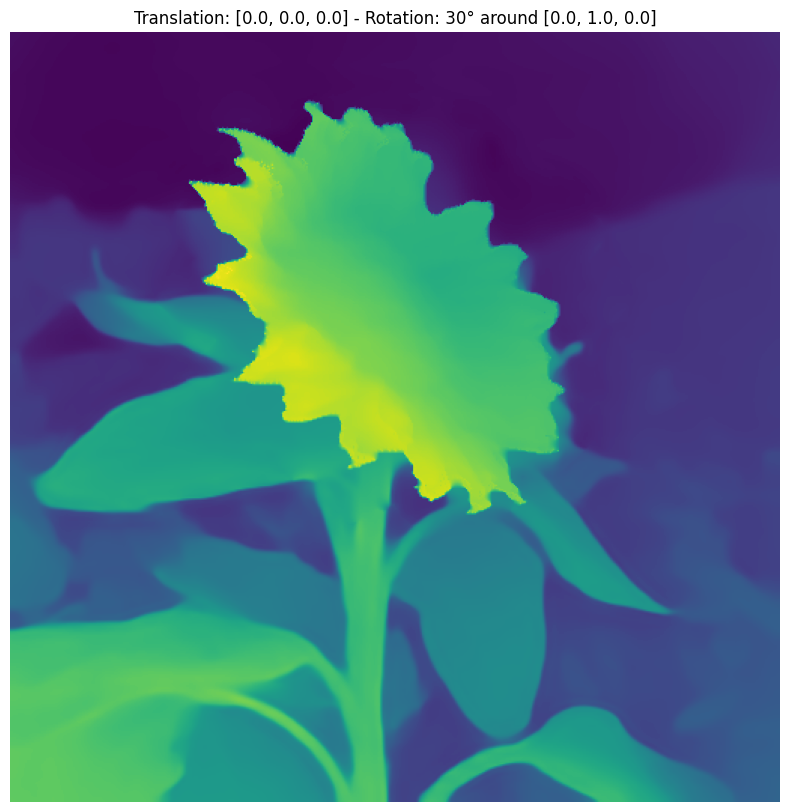

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt 
import scipy
import torch

from diffhandles.guided_stable_diffuser import GuidedStableDiffuser
from diffhandles.depth_transform import transform_depth, depth_to_points
from diffhandles.utils import solve_laplacian_depth

from test_diffusion_handles import load_diffhandles_inputs
    
sample_dir = 'data/sunflower'
translation = [0.0, 0.0, 0.0]
rot_axis = [0.0, 1.0, 0.0]
rot_angle = 30

img_res = 512

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img, fg_mask, depth, bg_depth = load_diffhandles_inputs(
    sample_dir=sample_dir, img_res=img_res, device=device)

cam_intrinsics = GuidedStableDiffuser.get_depth_intrinsics(h=img_res, w=img_res)

# infill hole in the depth of the input image (where the foreground object used to be)
# with the depth of the background image
print('infilling depth ...')
bg_depth = solve_laplacian_depth(
    depth[0, 0].cpu().numpy(),
    bg_depth[0, 0].cpu().numpy(),
    scipy.ndimage.binary_dilation(fg_mask[0, 0].cpu().numpy(), iterations=15))
bg_depth = torch.from_numpy(bg_depth).to(device=device)[None, None]

# edit the 3D points
print('editing points ...')
edited_disparity, target_mask, correspondences, raw_edited_depth = transform_depth(
    depth=depth, bg_depth=bg_depth, fg_mask=fg_mask,
    intrinsics=cam_intrinsics.to(device=depth.device),
    rot_angle=float(rot_angle),
    rot_axis=torch.tensor(rot_axis, dtype=torch.float32),
    translation=torch.tensor(translation, dtype=torch.float32),
    use_input_depth_normalization=False)

# plot the edited disparity
print('plotting ...')
edited_disparity = (edited_disparity - edited_disparity.min())/(edited_disparity.max() - edited_disparity.min())
img = (edited_disparity[0, 0].detach().cpu().numpy()*255).round().astype("uint8")
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.title(f'Translation: {translation} - Rotation: {rot_angle}° around {rot_axis}')
plt.show()